In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

## Define FCN16s model for deconvolution layers

In [2]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [3]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [4]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [5]:
batch_size = 12
epochs     = 100  #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 12
gamma      = 0.5
n_class = 4
model_use = "fcn"

## Define path, directory trainning environment

In [6]:
# get data
data_dir  = os.path.join("/media/arg_ws3/5E703E3A703E18EB/data/subt_all")
if not os.path.exists(data_dir):
    print("Data not found!")
# create dir for model
model_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models", model_use)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/scores", model_use)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Finish cuda loading, time elapsed 1.6100115776062012


In [7]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w

class product_dataset(Dataset):

    def __init__(self, csv_file, phase, n_class=n_class, flip_rate=0.):
        self.data      = pd.read_csv(csv_file)
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name   = self.data.iloc[idx, 0]
        img        = cv2.imread(os.path.join(data_dir, img_name),cv2.IMREAD_UNCHANGED)
        #print(os.path.join(data_dir, img_name))
        label_name = self.data.iloc[idx, 1]
        label      = cv2.imread(os.path.join(data_dir, label_name), cv2.IMREAD_GRAYSCALE)
        #print(os.path.join(data_dir, label_name))
        origin_img = img
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)
        
        for i in range(n_class):
            target[i][label == i] = 1
        
        #target[0][label == 0] = 1
        #print(np.unique(label))
        
 
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample

## Define dataloader and optimizer

In [16]:
# initial dataloader for trainning and validation
train_file = os.path.join(data_dir, "train.csv")
val_file   = os.path.join(data_dir, "test.csv")
train_data = product_dataset(csv_file = train_file, phase = 'train')
val_data   = product_dataset(csv_file = val_file, phase = 'val', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 1, num_workers = 0)

dataiter = iter(val_loader)

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr = lr, momentum = momentum, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

In [9]:
len(dataiter)

95

## Train

In [10]:
def train():
    for epoch in range(epochs):
        fcn_model.train()
        scheduler.step()
        configs    = "FCNs_batch{}_epoch{}_RMSprop_lr{}"\
            .format(batch_size, epoch, lr)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch+1, iter, loss.item()))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        if epoch % 4 == 0:
            torch.save(fcn_model.state_dict(),model_path + '.pkl')

        val(epoch)

## Evaluation

In [11]:
def val(epoch):
    fcn_model.eval()
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [12]:
train()

epoch1, iter0, loss: 0.760908842086792
epoch1, iter10, loss: 0.7308602929115295
epoch1, iter20, loss: 0.7318978309631348
epoch1, iter30, loss: 0.7162283658981323
epoch1, iter40, loss: 0.7095285654067993
epoch1, iter50, loss: 0.7048267722129822
epoch1, iter60, loss: 0.7102572917938232
epoch1, iter70, loss: 0.7041685581207275
epoch1, iter80, loss: 0.6951709389686584
epoch1, iter90, loss: 0.6866786479949951
epoch1, iter100, loss: 0.6935707330703735
epoch1, iter110, loss: 0.6794028878211975
epoch1, iter120, loss: 0.6800283789634705
epoch1, iter130, loss: 0.6740589737892151
epoch1, iter140, loss: 0.6667490005493164
epoch1, iter150, loss: 0.6682787537574768
epoch1, iter160, loss: 0.6716695427894592
epoch1, iter170, loss: 0.6688991189002991
epoch1, iter180, loss: 0.6912733912467957
epoch1, iter190, loss: 0.6558836698532104
epoch1, iter200, loss: 0.6595612168312073
epoch1, iter210, loss: 0.6580672264099121
epoch1, iter220, loss: 0.6612577438354492
epoch1, iter230, loss: 0.6495960354804993
epoc

epoch6, iter170, loss: 0.2173473834991455
epoch6, iter180, loss: 0.22393544018268585
epoch6, iter190, loss: 0.22752130031585693
epoch6, iter200, loss: 0.22118347883224487
epoch6, iter210, loss: 0.21630048751831055
epoch6, iter220, loss: 0.21295171976089478
epoch6, iter230, loss: 0.2226705253124237
epoch6, iter240, loss: 0.21531227231025696
epoch6, iter250, loss: 0.20939239859580994
epoch6, iter260, loss: 0.20616045594215393
epoch6, iter270, loss: 0.21344569325447083
epoch6, iter280, loss: 0.20701436698436737
Finish epoch 5, time elapsed 508.78884100914
epoch5, pix_acc: 0.9980429290312777, meanIoU: 0.8838302363136181, IoUs: [0.88386389 0.81696156 0.95066525], recall: [0.94916911 0.95249037 0.9883776 ], precision: [0.92777901 0.85166659 0.96141282], fscore: [0.93835218 0.89926125 0.97470876]
epoch7, iter0, loss: 0.19780662655830383
epoch7, iter10, loss: 0.20028358697891235
epoch7, iter20, loss: 0.19275066256523132
epoch7, iter30, loss: 0.19284549355506897
epoch7, iter40, loss: 0.18877391

Finish epoch 10, time elapsed 508.815771818161
epoch10, pix_acc: 0.9981303102204908, meanIoU: 0.8939936834861398, IoUs: [0.88404743 0.84796507 0.94996855], recall: [0.963353   0.91173928 0.99070982], precision: [0.91481271 0.92379684 0.95850706], fscore: [0.9384556  0.91772846 0.97434243]
epoch12, iter0, loss: 0.02395518496632576
epoch12, iter10, loss: 0.02328677847981453
epoch12, iter20, loss: 0.023915613070130348
epoch12, iter30, loss: 0.02306557260453701
epoch12, iter40, loss: 0.026993658393621445
epoch12, iter50, loss: 0.0221041701734066
epoch12, iter60, loss: 0.023329639807343483
epoch12, iter70, loss: 0.021293912082910538
epoch12, iter80, loss: 0.02126445062458515
epoch12, iter90, loss: 0.021652845665812492
epoch12, iter100, loss: 0.02105780318379402
epoch12, iter110, loss: 0.02058212272822857
epoch12, iter120, loss: 0.019954102113842964
epoch12, iter130, loss: 0.02003493532538414
epoch12, iter140, loss: 0.01849258877336979
epoch12, iter150, loss: 0.02041054703295231
epoch12, ite

epoch17, iter10, loss: 0.005115319509059191
epoch17, iter20, loss: 0.0052807629108428955
epoch17, iter30, loss: 0.005457750055938959
epoch17, iter40, loss: 0.005031515844166279
epoch17, iter50, loss: 0.004977785982191563
epoch17, iter60, loss: 0.005035846494138241
epoch17, iter70, loss: 0.004830053076148033
epoch17, iter80, loss: 0.004726204555481672
epoch17, iter90, loss: 0.00518807303160429
epoch17, iter100, loss: 0.005180026404559612
epoch17, iter110, loss: 0.005110293626785278
epoch17, iter120, loss: 0.004716388415545225
epoch17, iter130, loss: 0.006502375937998295
epoch17, iter140, loss: 0.004525176715105772
epoch17, iter150, loss: 0.005217109806835651
epoch17, iter160, loss: 0.004531605634838343
epoch17, iter170, loss: 0.004592010285705328
epoch17, iter180, loss: 0.005521230865269899
epoch17, iter190, loss: 0.004470990505069494
epoch17, iter200, loss: 0.004519259091466665
epoch17, iter210, loss: 0.004587468225508928
epoch17, iter220, loss: 0.0047020395286381245
epoch17, iter230, 

epoch22, iter60, loss: 0.002000721637159586
epoch22, iter70, loss: 0.0062631890177726746
epoch22, iter80, loss: 0.0020943041890859604
epoch22, iter90, loss: 0.0021922641899436712
epoch22, iter100, loss: 0.002479913178831339
epoch22, iter110, loss: 0.0018787281587719917
epoch22, iter120, loss: 0.002105915918946266
epoch22, iter130, loss: 0.0023868430871516466
epoch22, iter140, loss: 0.00193329481408
epoch22, iter150, loss: 0.0024166691582649946
epoch22, iter160, loss: 0.0018917578272521496
epoch22, iter170, loss: 0.002022422617301345
epoch22, iter180, loss: 0.0019256040686741471
epoch22, iter190, loss: 0.0021514082327485085
epoch22, iter200, loss: 0.001854484435170889
epoch22, iter210, loss: 0.0018795139621943235
epoch22, iter220, loss: 0.0018433047225698829
epoch22, iter230, loss: 0.002156007569283247
epoch22, iter240, loss: 0.002347559668123722
epoch22, iter250, loss: 0.0018934141844511032
epoch22, iter260, loss: 0.0018621301278471947
epoch22, iter270, loss: 0.001784644671715796
epoch

epoch27, iter100, loss: 0.0013645142316818237
epoch27, iter110, loss: 0.0013701070565730333
epoch27, iter120, loss: 0.001384466770105064
epoch27, iter130, loss: 0.001685609226115048
epoch27, iter140, loss: 0.0012908140197396278
epoch27, iter150, loss: 0.0011568962363526225
epoch27, iter160, loss: 0.0013291502837091684
epoch27, iter170, loss: 0.0015717187197878957
epoch27, iter180, loss: 0.0013131198938935995
epoch27, iter190, loss: 0.0015689246356487274
epoch27, iter200, loss: 0.010278604924678802
epoch27, iter210, loss: 0.0011305041844025254
epoch27, iter220, loss: 0.0013037637108936906
epoch27, iter230, loss: 0.0014087938470765948
epoch27, iter240, loss: 0.0015575835714116693
epoch27, iter250, loss: 0.0012974283890798688
epoch27, iter260, loss: 0.0011748872930184007
epoch27, iter270, loss: 0.0011954610235989094
epoch27, iter280, loss: 0.0013069527922198176
Finish epoch 26, time elapsed 509.1241011619568
epoch26, pix_acc: 0.9985830173104554, meanIoU: 0.9167736557511004, IoUs: [0.90767

epoch32, iter140, loss: 0.0010191946057602763
epoch32, iter150, loss: 0.0013980644289404154
epoch32, iter160, loss: 0.010364090092480183
epoch32, iter170, loss: 0.001063181203790009
epoch32, iter180, loss: 0.0010554358595982194
epoch32, iter190, loss: 0.0015168064273893833
epoch32, iter200, loss: 0.0010199366370216012
epoch32, iter210, loss: 0.001312579377554357
epoch32, iter220, loss: 0.0010175342904403806
epoch32, iter230, loss: 0.0011547708418220282
epoch32, iter240, loss: 0.0013594465563073754
epoch32, iter250, loss: 0.0010725809261202812
epoch32, iter260, loss: 0.0012349162716418505
epoch32, iter270, loss: 0.0017173531232401729
epoch32, iter280, loss: 0.0012856912799179554
Finish epoch 31, time elapsed 509.10658836364746
epoch31, pix_acc: 0.9985818343832892, meanIoU: 0.9160240332222193, IoUs: [0.90668404 0.87695122 0.96443684], recall: [0.95204465 0.91912027 0.97686658], precision: [0.95007441 0.95028364 0.98697851], fscore: [0.95105851 0.93444221 0.98189651]
epoch33, iter0, loss:

epoch37, iter180, loss: 0.0010259377304464579
epoch37, iter190, loss: 0.0010607895674183965
epoch37, iter200, loss: 0.0009289911831729114
epoch37, iter210, loss: 0.0010655864607542753
epoch37, iter220, loss: 0.0011310119880363345
epoch37, iter230, loss: 0.001191884744912386
epoch37, iter240, loss: 0.0009023943566717207
epoch37, iter250, loss: 0.0009001450380310416
epoch37, iter260, loss: 0.0010560783557593822
epoch37, iter270, loss: 0.0010507525876164436
epoch37, iter280, loss: 0.0008750956621952355
Finish epoch 36, time elapsed 509.1840195655823
epoch36, pix_acc: 0.9986222093280284, meanIoU: 0.9187053818650609, IoUs: [0.90972781 0.88089033 0.965498  ], recall: [0.95610113 0.93121957 0.98306003], precision: [0.94938324 0.94219226 0.98183309], fscore: [0.95273034 0.93667378 0.98244618]
epoch38, iter0, loss: 0.001009443774819374
epoch38, iter10, loss: 0.0009206607355736196
epoch38, iter20, loss: 0.0008679681341163814
epoch38, iter30, loss: 0.0010037667816504836
epoch38, iter40, loss: 0.0

epoch42, iter220, loss: 0.0008825848926790059
epoch42, iter230, loss: 0.0007932063308544457
epoch42, iter240, loss: 0.001003523007966578
epoch42, iter250, loss: 0.0008944647270254791
epoch42, iter260, loss: 0.0010579045629128814
epoch42, iter270, loss: 0.0007857331074774265
epoch42, iter280, loss: 0.0009480334701947868
Finish epoch 41, time elapsed 509.65730118751526
epoch41, pix_acc: 0.9986361022463527, meanIoU: 0.9191721216502419, IoUs: [0.90988709 0.88142265 0.96620663], recall: [0.9533495  0.92488368 0.98309212], precision: [0.95228644 0.94938591 0.98253386], fscore: [0.95281768 0.93697463 0.98281291]
epoch43, iter0, loss: 0.0010217333910986781
epoch43, iter10, loss: 0.0009105809731408954
epoch43, iter20, loss: 0.0009320185636170208
epoch43, iter30, loss: 0.0009791452903300524
epoch43, iter40, loss: 0.001094203907996416
epoch43, iter50, loss: 0.0007884823717176914
epoch43, iter60, loss: 0.0009614904993213713
epoch43, iter70, loss: 0.00071776716504246
epoch43, iter80, loss: 0.000829

epoch47, iter260, loss: 0.0008175172843039036
epoch47, iter270, loss: 0.0008268894162029028
epoch47, iter280, loss: 0.0008360713836736977
Finish epoch 46, time elapsed 509.3884160518646
epoch46, pix_acc: 0.9986252918462643, meanIoU: 0.9193886087643605, IoUs: [0.91032201 0.88201919 0.96582463], recall: [0.96413993 0.93895022 0.982842  ], precision: [0.94222419 0.93567865 0.9823886 ], fscore: [0.95305609 0.93731158 0.98261525]
epoch48, iter0, loss: 0.0010012021521106362
epoch48, iter10, loss: 0.0008790533756837249
epoch48, iter20, loss: 0.0007675524102523923
epoch48, iter30, loss: 0.0008628467912785709
epoch48, iter40, loss: 0.0007938808994367719
epoch48, iter50, loss: 0.000847090792376548
epoch48, iter60, loss: 0.0011305012740194798
epoch48, iter70, loss: 0.0006638113991357386
epoch48, iter80, loss: 0.000788496749009937
epoch48, iter90, loss: 0.0007662345306016505
epoch48, iter100, loss: 0.0007429016986861825
epoch48, iter110, loss: 0.0007710385252721608
epoch48, iter120, loss: 0.000879

epoch51, pix_acc: 0.9985980672524314, meanIoU: 0.9179515173574357, IoUs: [0.9055678  0.88249584 0.96579091], recall: [0.94688457 0.92959045 0.98386418], precision: [0.95403042 0.94570941 0.98133467], fscore: [0.95044406 0.93758065 0.9825978 ]
epoch53, iter0, loss: 0.0008766549290157855
epoch53, iter10, loss: 0.000761928444262594
epoch53, iter20, loss: 0.000605003850068897
epoch53, iter30, loss: 0.0006582308560609818
epoch53, iter40, loss: 0.0008740056655369699
epoch53, iter50, loss: 0.0007097956840880215
epoch53, iter60, loss: 0.0006681333761662245
epoch53, iter70, loss: 0.0007375336717814207
epoch53, iter80, loss: 0.0007757258717902005
epoch53, iter90, loss: 0.0007669547339901328
epoch53, iter100, loss: 0.0007676745881326497
epoch53, iter110, loss: 0.0006762651028111577
epoch53, iter120, loss: 0.0009364279103465378
epoch53, iter130, loss: 0.0007454978185705841
epoch53, iter140, loss: 0.000730436178855598
epoch53, iter150, loss: 0.0006671783630736172
epoch53, iter160, loss: 0.000827407

epoch58, iter0, loss: 0.0008025614661164582
epoch58, iter10, loss: 0.0007550048758275807
epoch58, iter20, loss: 0.0006362725980579853
epoch58, iter30, loss: 0.0007477017934434116
epoch58, iter40, loss: 0.0005934706423431635
epoch58, iter50, loss: 0.0006714095361530781
epoch58, iter60, loss: 0.0007880364428274333
epoch58, iter70, loss: 0.0006673316238448024
epoch58, iter80, loss: 0.0009087697835639119
epoch58, iter90, loss: 0.0007303999736905098
epoch58, iter100, loss: 0.0006151040433906019
epoch58, iter110, loss: 0.0007539473590441048
epoch58, iter120, loss: 0.0008496531518176198
epoch58, iter130, loss: 0.0007567442953586578
epoch58, iter140, loss: 0.0007449965341947973
epoch58, iter150, loss: 0.0006997965392656624
epoch58, iter160, loss: 0.0007582465186715126
epoch58, iter170, loss: 0.0007130012381821871
epoch58, iter180, loss: 0.0007108391728252172
epoch58, iter190, loss: 0.0006403113948181272
epoch58, iter200, loss: 0.0007098717615008354
epoch58, iter210, loss: 0.0005931732011958957

epoch63, iter40, loss: 0.0007771612727083266
epoch63, iter50, loss: 0.000730286119505763
epoch63, iter60, loss: 0.0006488501094281673
epoch63, iter70, loss: 0.0006653282325714827
epoch63, iter80, loss: 0.0006007287884131074
epoch63, iter90, loss: 0.0008930538897402585
epoch63, iter100, loss: 0.0005932010826654732
epoch63, iter110, loss: 0.0006628339178860188
epoch63, iter120, loss: 0.0007256839307956398
epoch63, iter130, loss: 0.0006775042857043445
epoch63, iter140, loss: 0.0006319264648482203
epoch63, iter150, loss: 0.0005655462155118585
epoch63, iter160, loss: 0.0005476722144521773
epoch63, iter170, loss: 0.0006624806555919349
epoch63, iter180, loss: 0.0008020942914299667
epoch63, iter190, loss: 0.000639023317489773
epoch63, iter200, loss: 0.0006835327949374914
epoch63, iter210, loss: 0.0006219319766387343
epoch63, iter220, loss: 0.0007514861063100398
epoch63, iter230, loss: 0.0006714320625178516
epoch63, iter240, loss: 0.0007475563324987888
epoch63, iter250, loss: 0.0006094687269069

epoch68, iter80, loss: 0.0007983130635693669
epoch68, iter90, loss: 0.0006153557333163917
epoch68, iter100, loss: 0.0005562700098380446
epoch68, iter110, loss: 0.0005938771064393222
epoch68, iter120, loss: 0.0007087052217684686
epoch68, iter130, loss: 0.0006332698394544423
epoch68, iter140, loss: 0.0006042266031727195
epoch68, iter150, loss: 0.0006595040904358029
epoch68, iter160, loss: 0.000660447811242193
epoch68, iter170, loss: 0.00068045494845137
epoch68, iter180, loss: 0.0006237222114577889
epoch68, iter190, loss: 0.0006466141203418374
epoch68, iter200, loss: 0.0006497603608295321
epoch68, iter210, loss: 0.00065849837847054
epoch68, iter220, loss: 0.0006975370342843235
epoch68, iter230, loss: 0.000580759544391185
epoch68, iter240, loss: 0.0007523975800722837
epoch68, iter250, loss: 0.0031352313235402107
epoch68, iter260, loss: 0.0006751771434210241
epoch68, iter270, loss: 0.0007078674389049411
epoch68, iter280, loss: 0.0007710267091169953
Finish epoch 67, time elapsed 509.82499170

epoch73, iter120, loss: 0.000683901715092361
epoch73, iter130, loss: 0.0006179201882332563
epoch73, iter140, loss: 0.0006132273119874299
epoch73, iter150, loss: 0.0006345302681438625
epoch73, iter160, loss: 0.0005071759223937988
epoch73, iter170, loss: 0.0006513547850772738
epoch73, iter180, loss: 0.00058675033506006
epoch73, iter190, loss: 0.0005364877288229764
epoch73, iter200, loss: 0.0005920740077272058
epoch73, iter210, loss: 0.0008118175901472569
epoch73, iter220, loss: 0.0006135011790320277
epoch73, iter230, loss: 0.0006095979479141533
epoch73, iter240, loss: 0.000581405300181359
epoch73, iter250, loss: 0.0006318231462500989
epoch73, iter260, loss: 0.0007670948398299515
epoch73, iter270, loss: 0.0006883076275698841
epoch73, iter280, loss: 0.0007024549413472414
Finish epoch 72, time elapsed 509.4596800804138
epoch72, pix_acc: 0.9986223215765916, meanIoU: 0.9189290454769122, IoUs: [0.90948334 0.8818586  0.9654452 ], recall: [0.95595497 0.93056255 0.98306003], precision: [0.9492610

epoch78, iter160, loss: 0.0006054783007130027
epoch78, iter170, loss: 0.0006102500483393669
epoch78, iter180, loss: 0.0005464262212626636
epoch78, iter190, loss: 0.000656189804431051
epoch78, iter200, loss: 0.0007498678169213235
epoch78, iter210, loss: 0.0006069419905543327
epoch78, iter220, loss: 0.000517284672241658
epoch78, iter230, loss: 0.0006702623213641346
epoch78, iter240, loss: 0.0005952432402409613
epoch78, iter250, loss: 0.0006003643502481282
epoch78, iter260, loss: 0.0005864545237272978
epoch78, iter270, loss: 0.0005804917891509831
epoch78, iter280, loss: 0.0006846620817668736
Finish epoch 77, time elapsed 509.8506226539612
epoch77, pix_acc: 0.9986226755912909, meanIoU: 0.9191735729095092, IoUs: [0.90959812 0.88231164 0.96561096], recall: [0.95798214 0.93675628 0.98319783], precision: [0.9473951  0.9381982  0.98181246], fscore: [0.95265921 0.93747669 0.98250466]
epoch79, iter0, loss: 0.000633710587862879
epoch79, iter10, loss: 0.0005406152340583503
epoch79, iter20, loss: 0.

epoch83, iter200, loss: 0.0006715744384564459
epoch83, iter210, loss: 0.0005905632278881967
epoch83, iter220, loss: 0.0006069024093449116
epoch83, iter230, loss: 0.0006589533295482397
epoch83, iter240, loss: 0.0006010463694110513
epoch83, iter250, loss: 0.0006181958015076816
epoch83, iter260, loss: 0.0005504952860064805
epoch83, iter270, loss: 0.0006219943752512336
epoch83, iter280, loss: 0.0005628135404549539
Finish epoch 82, time elapsed 509.27026295661926
epoch82, pix_acc: 0.9986218984858533, meanIoU: 0.9189097268700006, IoUs: [0.9094525  0.88184199 0.96543469], recall: [0.95559698 0.93267964 0.98195952], precision: [0.9495807  0.94178765 0.9828677 ], fscore: [0.95257934 0.93721152 0.9824134 ]
epoch84, iter0, loss: 0.0005819376674480736
epoch84, iter10, loss: 0.0005944754811935127
epoch84, iter20, loss: 0.0005714765284210443
epoch84, iter30, loss: 0.0005395974148996174
epoch84, iter40, loss: 0.0005963567527942359
epoch84, iter50, loss: 0.0005520924460142851
epoch84, iter60, loss: 0.

epoch88, iter240, loss: 0.0005639165756292641
epoch88, iter250, loss: 0.000441791518824175
epoch88, iter260, loss: 0.0006349176401272416
epoch88, iter270, loss: 0.0006658511701971292
epoch88, iter280, loss: 0.0006071542738936841
Finish epoch 87, time elapsed 509.9546604156494
epoch87, pix_acc: 0.9986209227868037, meanIoU: 0.9190516650467754, IoUs: [0.90953462 0.88223063 0.96538974], recall: [0.95683828 0.93579571 0.98324502], precision: [0.94844744 0.93907193 0.98153672], fscore: [0.95262438 0.93743096 0.98239013]
epoch89, iter0, loss: 0.0006329197785817087
epoch89, iter10, loss: 0.0006903522880747914
epoch89, iter20, loss: 0.000669114466290921
epoch89, iter30, loss: 0.0005657689180225134
epoch89, iter40, loss: 0.0005212161340750754
epoch89, iter50, loss: 0.0006316556828096509
epoch89, iter60, loss: 0.0005641840980388224
epoch89, iter70, loss: 0.0005794963799417019
epoch89, iter80, loss: 0.0005861668032594025
epoch89, iter90, loss: 0.0006434320821426809
epoch89, iter100, loss: 0.000607

epoch93, iter280, loss: 0.000625802087597549
Finish epoch 92, time elapsed 509.60456919670105
epoch92, pix_acc: 0.9986162774231874, meanIoU: 0.9188187403243141, IoUs: [0.9091438  0.88204879 0.96526363], recall: [0.95655232 0.93401674 0.98329788], precision: [0.94830336 0.94066341 0.98135371], fscore: [0.95240998 0.93732829 0.98232483]
epoch94, iter0, loss: 0.0005015608621761203
epoch94, iter10, loss: 0.000611580500844866
epoch94, iter20, loss: 0.0006402615108527243
epoch94, iter30, loss: 0.0005133714876137674
epoch94, iter40, loss: 0.0006381918210536242
epoch94, iter50, loss: 0.0008207886130549014
epoch94, iter60, loss: 0.0005399305955506861
epoch94, iter70, loss: 0.0005556016694754362
epoch94, iter80, loss: 0.000679965945892036
epoch94, iter90, loss: 0.0005378341302275658
epoch94, iter100, loss: 0.0005544359446503222
epoch94, iter110, loss: 0.0007130748708732426
epoch94, iter120, loss: 0.0007279731798917055
epoch94, iter130, loss: 0.0006356884259730577
epoch94, iter140, loss: 0.000518

epoch99, iter0, loss: 0.0005409328150562942
epoch99, iter10, loss: 0.0005377153283916414
epoch99, iter20, loss: 0.0006988306995481253
epoch99, iter30, loss: 0.0005340093630366027
epoch99, iter40, loss: 0.0005457298248074949
epoch99, iter50, loss: 0.0005423922557383776
epoch99, iter60, loss: 0.0006643935339525342
epoch99, iter70, loss: 0.0005176024278625846
epoch99, iter80, loss: 0.0005563519080169499
epoch99, iter90, loss: 0.000586748297791928
epoch99, iter100, loss: 0.0006296720239333808
epoch99, iter110, loss: 0.0006200284697115421
epoch99, iter120, loss: 0.0005882164114154875
epoch99, iter130, loss: 0.0005936162197031081
epoch99, iter140, loss: 0.0005417894572019577
epoch99, iter150, loss: 0.0005676618311554193
epoch99, iter160, loss: 0.0005447881412692368
epoch99, iter170, loss: 0.0005422398680821061
epoch99, iter180, loss: 0.0005394700565375388
epoch99, iter190, loss: 0.0005411023157648742
epoch99, iter200, loss: 0.0006426197360269725
epoch99, iter210, loss: 0.0006669052527286112


## Prediction Result

In [17]:
def prediction(model_name):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    
    batch = dataiter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])
    img    = batch['origin'] 
    label  = batch['l']
    
    #print(img.shape, inputs.shape)
    #print(inputs[0])
    
    output = fcn_model(inputs)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

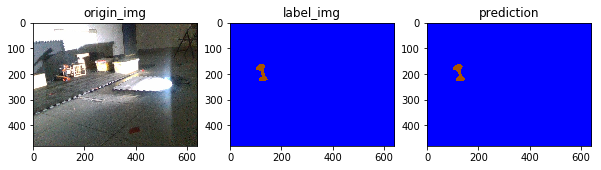

In [22]:
prediction("FCNs_batch12_epoch64_RMSprop_lr0.0001.pkl")